In [326]:
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import xgboost
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import random

import shap

os.environ["PATH"] += (os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/')

In [3]:
xgb_model = joblib.load(open('xgb_50.model', 'rb'))

xgb_X_test = joblib.load('xgb_X_test.joblib')   # RUL 제외 28개 + add_X_col(['cycle', 'Fc'])
xgb_y_test = joblib.load('xgb_y_test.joblib')
xgb_y_pred = joblib.load('xgb_y_pred.joblib')
df_xgb_y_pred = pd.DataFrame(xgb_y_pred, columns=['f_mode'])

xgb_X_full_test = joblib.load('xgb_X_full_test.joblib') # fileNo, unit 포함 버전
xgb_label_dic = joblib.load('xgb_label_dic.joblib')
# scaler = pickle.load(open('minmax_scaler.pkl', 'rb'))

xgb_X_actual = xgb_X_full_test.loc[:, (xgb_X_full_test.columns != 'fileNo') & (xgb_X_full_test.columns != 'unit')] # sacle 하기 전 원래 값


In [4]:
xgb_X_full_test.columns

Index(['climb_hpt_entry_press_ratio_mean', 'climb_P15_std',
       'climb_hpt_hpc_press_mean', 'climb_hpt_hpc_press_ratio_mean',
       'climb_SmFan_mean', 'climb_P2_std', 'cruise_SmHPC_mean',
       'climb_alt_min', 'climb_SmHPC_mean', 'climb_hpt_hpc_temp_mean',
       'climb_fan_exit_press_min', 'climb_hpt_hpc_press_min',
       'climb_hpt_entry_temp_drop_mean', 'climb_hpt_entry_temp_drop_min',
       'cruise_hpt_entry_temp_drop_mean', 'climb_hpt_entry_press_ratio_max',
       'climb_W31_std', 'climb_hpc_lpc_temp_max', 'climb_SmLPC_max',
       'climb_hpt_hpc_temp_ratio_mean', 'climb_T30_max',
       'cruise_hpt_hpc_press_min', 'climb_hpt_hpc_press_ratio_max',
       'climb_P30_std', 'cruise_hpt_entry_press_ratio_max', 'climb_P50_std',
       'climb_W22_std', 'cruise_hpt_hpc_press_ratio_max', 'fileNo', 'unit',
       'cycle', 'Fc'],
      dtype='object')

In [5]:
xgb_label_dic

{0: 'all',
 1: 'fan',
 2: 'healthy',
 3: 'hpc',
 4: 'hpc+lpc',
 5: 'hpt',
 6: 'hpt+lpt',
 7: 'lpt'}

In [11]:
# 고장 모드별 분석을 위해 index 분리
hpt_unitNo = ((xgb_X_full_test.fileNo == 0) & (xgb_X_full_test.unit.isin([7,8,9,10])))
hpt_lpt_unitNo = (((xgb_X_full_test.fileNo == 2) & (xgb_X_full_test.unit.isin([10,11,12,13,14,15]))) | ((xgb_X_full_test.fileNo == 1) & (xgb_X_full_test.unit.isin([11,14,15]))))
fan_unitNo = ((xgb_X_full_test.fileNo == 3) & (xgb_X_full_test.unit.isin([7,8,9,10])))
hpc_unitNo = ((xgb_X_full_test.fileNo == 4) & (xgb_X_full_test.unit.isin([7,8,9,10])))
hpc_lpc_unitNo = ((xgb_X_full_test.fileNo == 5) & (xgb_X_full_test.unit.isin([7,8,9,10])))
lpt_unitNo = ((xgb_X_full_test.fileNo == 6) & (xgb_X_full_test.unit.isin([7,8,9,10])))
all_unitNo = (((xgb_X_full_test.fileNo == 7) & (xgb_X_full_test.unit.isin([10,11,12,13,14,15]))) | ((xgb_X_full_test.fileNo == 8) & (xgb_X_full_test.unit.isin([7,8,9,10]))))

# 실험에 사용된 데이터(scaled)를 고장 모드별로 구분
hpt_X = xgb_X_test.iloc[xgb_X_full_test[hpt_unitNo].index]
hpt_lpt_X = xgb_X_test.iloc[xgb_X_full_test[hpt_lpt_unitNo].index]
fan_X = xgb_X_test.iloc[xgb_X_full_test[fan_unitNo].index]
hpc_X = xgb_X_test.iloc[xgb_X_full_test[hpc_unitNo].index]
hpc_lpc_X = xgb_X_test.iloc[xgb_X_full_test[hpc_lpc_unitNo].index]
lpt_X = xgb_X_test.iloc[xgb_X_full_test[lpt_unitNo].index]
all_X = xgb_X_test.iloc[xgb_X_full_test[all_unitNo].index]

def getModeData(mode, flag) :
    X = None
    y = None
    idx = None
    if mode == 'hpt' :
        idx = hpt_X.index
    elif mode == 'fan' :
        idx = fan_X.index
    elif mode == 'hpc' :
        idx = hpc_X.index
    elif mode == 'lpt' :
        idx = lpt_X.index
    elif mode == 'hpt_lpt' :
        idx = hpt_lpt_X.index
    elif mode == 'all' :
        idx = all_X.index
    
    if flag == 'actual' :
        X = xgb_X_actual.iloc[idx]
    elif flag == 'test' :
        X = xgb_X_test.iloc[idx]
    
    y = pd.DataFrame(xgb_y_test.iloc[idx], columns=['f_mode'])

    return X, y

In [6]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(xgb_X_test)

[16:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [7]:
# 고장 모드별 변수 중요도
for s in range(len(shap_values)) :
    print(f'Class - {xgb_label_dic[s]}' )

    vals= np.abs(shap_values[s]).mean(0)
    feature_importance = pd.DataFrame(list(zip(xgb_X_test.columns, vals)),columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
    display(feature_importance.head(10))
    print('========================================================================')

Class - all


,col_name,feature_importance_vals
4,climb_SmFan_mean,1.604020
28,cycle,1.210776
8,climb_SmHPC_mean,0.859761
12,climb_hpt_entry_temp_drop_mean,0.715025
10,climb_fan_exit_press_min,0.527076
0,climb_hpt_entry_press_ratio_mean,0.494397
13,climb_hpt_entry_temp_drop_min,0.414535
9,climb_hpt_hpc_temp_mean,0.413693
17,climb_hpc_lpc_temp_max,0.320939
19,climb_hpt_hpc_temp_ratio_mean,0.296227


Class - fan


,col_name,feature_importance_vals
24,cruise_hpt_entry_press_ratio_max,0.858419
28,cycle,0.789587
29,Fc,0.716865
4,climb_SmFan_mean,0.697788
8,climb_SmHPC_mean,0.683498
18,climb_SmLPC_max,0.607031
19,climb_hpt_hpc_temp_ratio_mean,0.593444
14,cruise_hpt_entry_temp_drop_mean,0.584489
10,climb_fan_exit_press_min,0.515556
9,climb_hpt_hpc_temp_mean,0.492764


Class - healthy


,col_name,feature_importance_vals
28,cycle,5.516542
29,Fc,1.172793
4,climb_SmFan_mean,0.347072
19,climb_hpt_hpc_temp_ratio_mean,0.200942
9,climb_hpt_hpc_temp_mean,0.183966
17,climb_hpc_lpc_temp_max,0.172923
6,cruise_SmHPC_mean,0.136795
12,climb_hpt_entry_temp_drop_mean,0.108693
13,climb_hpt_entry_temp_drop_min,0.105735
7,climb_alt_min,0.105518


Class - hpc


,col_name,feature_importance_vals
18,climb_SmLPC_max,1.509986
10,climb_fan_exit_press_min,1.197963
13,climb_hpt_entry_temp_drop_min,0.962899
8,climb_SmHPC_mean,0.716351
6,cruise_SmHPC_mean,0.514886
28,cycle,0.510377
4,climb_SmFan_mean,0.493245
20,climb_T30_max,0.465854
0,climb_hpt_entry_press_ratio_mean,0.362285
17,climb_hpc_lpc_temp_max,0.330379


Class - hpc+lpc


,col_name,feature_importance_vals
18,climb_SmLPC_max,1.358888
8,climb_SmHPC_mean,1.138270
28,cycle,0.719981
20,climb_T30_max,0.620759
13,climb_hpt_entry_temp_drop_min,0.602238
10,climb_fan_exit_press_min,0.567577
15,climb_hpt_entry_press_ratio_max,0.538003
4,climb_SmFan_mean,0.486037
0,climb_hpt_entry_press_ratio_mean,0.420214
9,climb_hpt_hpc_temp_mean,0.390705


Class - hpt


,col_name,feature_importance_vals
28,cycle,1.095903
13,climb_hpt_entry_temp_drop_min,1.069787
17,climb_hpc_lpc_temp_max,0.759524
10,climb_fan_exit_press_min,0.689945
20,climb_T30_max,0.662842
0,climb_hpt_entry_press_ratio_mean,0.636227
7,climb_alt_min,0.501106
15,climb_hpt_entry_press_ratio_max,0.498607
18,climb_SmLPC_max,0.376742
6,cruise_SmHPC_mean,0.290886


Class - hpt+lpt


,col_name,feature_importance_vals
11,climb_hpt_hpc_press_min,0.868013
20,climb_T30_max,0.865888
0,climb_hpt_entry_press_ratio_mean,0.690581
13,climb_hpt_entry_temp_drop_min,0.673087
28,cycle,0.627713
17,climb_hpc_lpc_temp_max,0.473666
2,climb_hpt_hpc_press_mean,0.448105
10,climb_fan_exit_press_min,0.445916
3,climb_hpt_hpc_press_ratio_mean,0.373443
8,climb_SmHPC_mean,0.331863


Class - lpt


,col_name,feature_importance_vals
2,climb_hpt_hpc_press_mean,1.350514
13,climb_hpt_entry_temp_drop_min,0.882891
0,climb_hpt_entry_press_ratio_mean,0.861354
19,climb_hpt_hpc_temp_ratio_mean,0.724056
11,climb_hpt_hpc_press_min,0.714261
9,climb_hpt_hpc_temp_mean,0.515754
28,cycle,0.379199
15,climb_hpt_entry_press_ratio_max,0.302361
14,cruise_hpt_entry_temp_drop_mean,0.298571
4,climb_SmFan_mean,0.274451


## 시나리오 2. 공정 최적화를 위한 정비 우선순위 검증

- 가설
1) 고장난 부품이 수리되거나 교체된 후 관련 센서값은 고장나기 전의 센서값과 비슷할 것이다.
2) 단독 고장 모드 데이터셋의 고장일때, 부품이 교체되었다고 가정 후 주요지표를 고장나기 전의 센서 통계값으로 교체하면 전체 hs 카운트는 늘어날 것이다. (특정 range로 random value를 만들면 할때마다 결과가 달라져서 여기서는 고정값으로 처리함)
3) ALL 고장 모드 데이터셋의 고장일때 센서값은 각 부품의 고장으로 인해 그에 해당하는 센서값이 변한 부분도 있고, 고장난 부품간의 상호관계에 의해 센서값이 안좋아진 경우도 있겠지만, 여기서는 각 부품별 고장에 대한 임팩트만 고려한다.
4) 고장난 부품이 각각 수리되었다고 가정하고, 부품별 주요 지표의 값을 2번 실험 결과 기반으로 바꿨을 때, ALL 고장 모드에서도 hs 카운트가 변화할 것이다.
5) 각 부품별로 hs count가 늘어나는 수를 비교하여 어떤 부품 교체가 hs를 더 늘리는지 관찰한다.

- 한계
1) feature를 축약하면서 부품 각각에 대한 feature가 비슷한 양만큼 추출되지 않았음 (주로 hpt 관련 feature가 많이 추출되었음)
2) top5 feature 대상으로만 시뮬레이션 해봄

In [358]:
def show_dependence_plot(columns, label_idx, X_actual) :
    fig, axes = plt.subplots(1,len(columns), figsize=(len(columns)*5+2, 5), constrained_layout=True)
    # fig, axes = plt.subplots(len(columns),1, figsize=(3, 10))
    for i in range(len(columns)) :
        f_idx = xgb_X_test.columns.get_loc(columns[i])
        shap.dependence_plot(f_idx, shap_values[label_idx][X_actual.index], X_actual, cmap = 'bwr', show=False, ax=axes[i])
        axes[i].tick_params(axis='x', rotation=45)
    plt.show()

def show_scatterplot(data, columns, y_col, hue_col) :
    fig, ax = plt.subplots(ncols=len(columns), figsize=(len(columns)*3+1,3), constrained_layout=True)
    for idx, col in enumerate(columns) :
        sns.scatterplot(data=data, x=y_col, y=col, hue=hue_col, ax=ax[idx])
    plt.show()

def calc_accuracy(X_simulated, y_actual, y_pred, flag='') :
    print(f'[{flag} 기준 accuracy]')
    # simulated된 조건으로 고장모드를 구분했을 경우
    y_actual_simulated = pd.DataFrame(y_actual.loc[X_simulated.index], columns=['f_mode'])
    y_pred_simulated = pd.DataFrame(y_pred.loc[X_simulated.index], columns=['f_mode'])
    print(y_actual_simulated.value_counts())

    print(f'total count : {y_actual_simulated.value_counts().sum()} vs {y_actual.value_counts().sum()} / {round(y_actual_simulated.value_counts().sum() / y_actual.value_counts().sum(), 2)}')
    print(f'simulation actual accuracy : {round(y_actual_simulated.value_counts().iloc[0] / y_actual_simulated.value_counts().sum(), 2)}')
    print(f'simulation pred accuracy : {round(y_pred_simulated.value_counts().iloc[0] / y_pred_simulated.value_counts().sum(), 2)}')
    print()

def makeRangeValue(lower, upper, num, colname) :
    random_list = []

    for i in range(num) :
        random_value = round(random.uniform(lower, upper), 5)
        random_list.append(random_value)
    return pd.DataFrame(random_list, columns=[colname])

# xgboost
def eval_xgb(X_test, y_test) :
    xgb_pred = xgb_model.predict(X_test)

    f1 = f1_score(y_test, xgb_pred, average='weighted')
    accuracy = accuracy_score(y_test, xgb_pred)
    precision = precision_score(y_test, xgb_pred, average='weighted')
    recall = recall_score(y_test, xgb_pred, average='weighted')
    # print(f"accuracy: {accuracy}")
    # print(f"f1: {f1}")
    # print(f"precision: {precision}")
    # print(f"recall: {recall}")

    return xgb_pred

def getTotalDf(X, y) :
    total_df = X.copy()
    total_df['f_mode'] = y.copy()
    total_df['unit'] = xgb_X_full_test.loc[total_df.index, 'unit']
    total_df['fileNo'] = xgb_X_full_test.loc[total_df.index, 'fileNo']
    
    return total_df

def changeValue(total_df, feature_list) :
    unit_group = total_df.groupby('unit')
    unit_adj_list = []
    for idx, unit in unit_group :
        for feature, agg_func in feature_list.items():
            # col_val = unit[feature][0:5].max()
            # unit.loc[(unit.f_mode !=2), feature] = col_val
            agg = agg_func.split('/')
            if agg[0] == 'quantile' :
                col_val = unit.loc[unit.f_mode == 2, feature].agg(agg[0], q=float(agg[1]))
            else :
                col_val = unit.loc[unit.f_mode == 2, feature].agg(agg[0])
            unit[feature] = col_val
        unit_adj_list.append(unit)

    return pd.concat(unit_adj_list, axis=0)



- top feature중 scatterplot을 확인했을 때 고장/정상 값들이 어느정도 구분이 가능한 경우, shap.summary_plot의 부호와 양상을 참고하여 max, quantile(0.75), quantile(0.25), min, mean 으로 시뮬레이션하여 가장 hs 수가 많이 늘어난 조건을 사용
- hpc는 값을 바꿨을 때 hs 수가 더 감소했으나, 동일 조건 all에 사용시 hs 늘어남

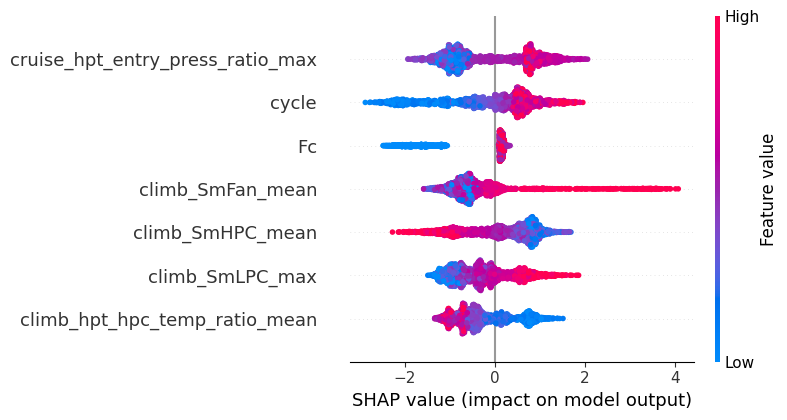

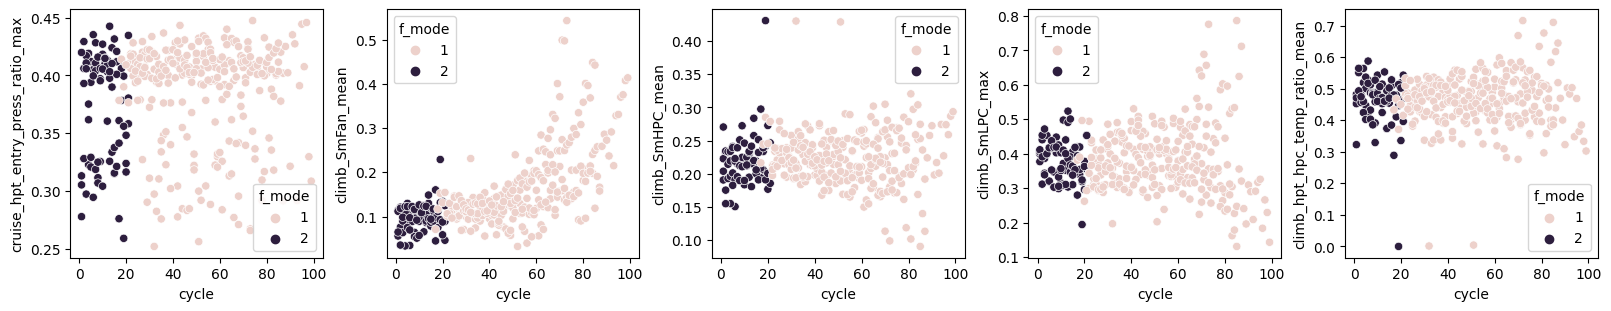

origin pred health vs failure : 79 vs 265
adjust pred health vs failure : 91 vs 253


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [378]:
# fan
label_idx = 1
fan_X_test, fan_y_test = getModeData('fan', 'test')
fan_total = getTotalDf(fan_X_test, fan_y_test)

fan_cols = ['cruise_hpt_entry_press_ratio_max', 'climb_SmFan_mean', 'climb_SmHPC_mean', 'climb_SmLPC_max', 'climb_hpt_hpc_temp_ratio_mean']

shap.summary_plot(shap_values[label_idx], xgb_X_test, class_names=xgb_label_dic, max_display=7)
show_scatterplot(fan_total, fan_cols, 'cycle', 'f_mode')

all_fan_top_feature_list = {'cruise_hpt_entry_press_ratio_max':'quantile/0.25', 'climb_SmFan_mean':'min'}
all_fan_adj = changeValue(fan_total, all_fan_top_feature_list)

all_fan_adj_pred = eval_xgb(all_fan_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), all_fan_adj['f_mode'])
df_all_fan_adj_pred = pd.DataFrame(all_fan_adj_pred, columns=['f_mode'])

print(f'origin pred health vs failure : {len(all_fan_adj.loc[all_fan_adj.f_mode == 2])} vs {len(all_fan_adj.loc[all_fan_adj.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_all_fan_adj_pred.loc[df_all_fan_adj_pred.f_mode == 2])} vs {len(df_all_fan_adj_pred.loc[df_all_fan_adj_pred.f_mode != 2])}')

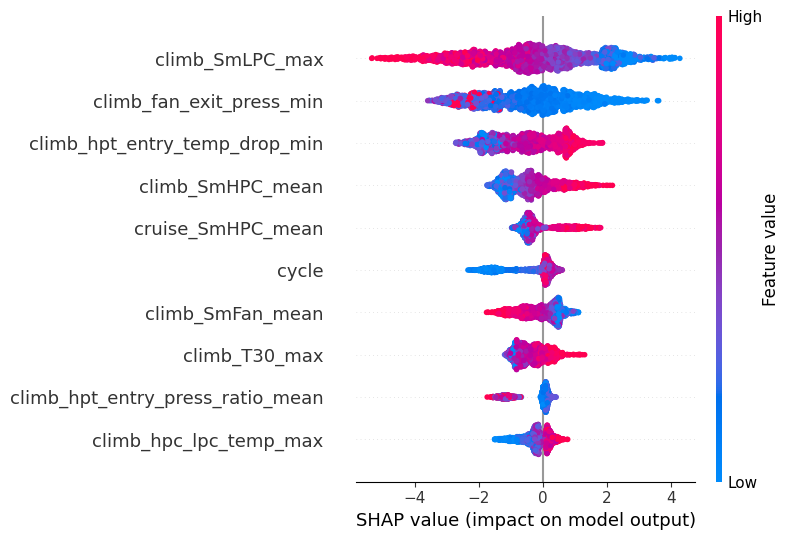

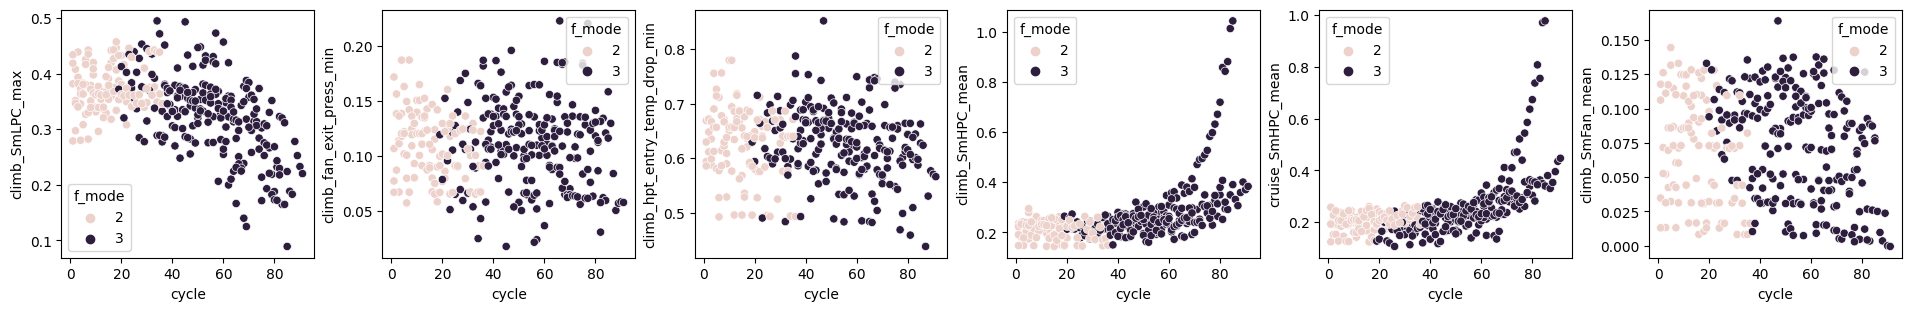

origin pred health vs failure : 112 vs 215
adjust pred health vs failure : 108 vs 219


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [450]:
# hpc
label_idx = 3
hpc_X_test, hpc_y_test = getModeData('hpc', 'test')
hpc_total = getTotalDf(hpc_X_test, hpc_y_test)

hpc_cols = ['climb_SmLPC_max', 'climb_fan_exit_press_min', 'climb_hpt_entry_temp_drop_min', 'climb_SmHPC_mean', 'cruise_SmHPC_mean', 'climb_SmFan_mean']

shap.summary_plot(shap_values[label_idx], xgb_X_test, class_names=xgb_label_dic, max_display=10)
show_scatterplot(hpc_total, hpc_cols, 'cycle', 'f_mode')

all_hpc_top_feature_list = {'cruise_SmHPC_mean':'min', 'climb_SmLPC_max':'quantile/0.75'}
all_hpc_adj = changeValue(hpc_total, all_hpc_top_feature_list)

all_hpc_adj_pred = eval_xgb(all_hpc_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), all_hpc_adj['f_mode'])
df_all_hpc_adj_pred = pd.DataFrame(all_hpc_adj_pred, columns=['f_mode'])

print(f'origin pred health vs failure : {len(all_hpc_adj.loc[all_hpc_adj.f_mode == 2])} vs {len(all_hpc_adj.loc[all_hpc_adj.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_all_hpc_adj_pred.loc[df_all_hpc_adj_pred.f_mode == 2])} vs {len(df_all_hpc_adj_pred.loc[df_all_hpc_adj_pred.f_mode != 2])}')

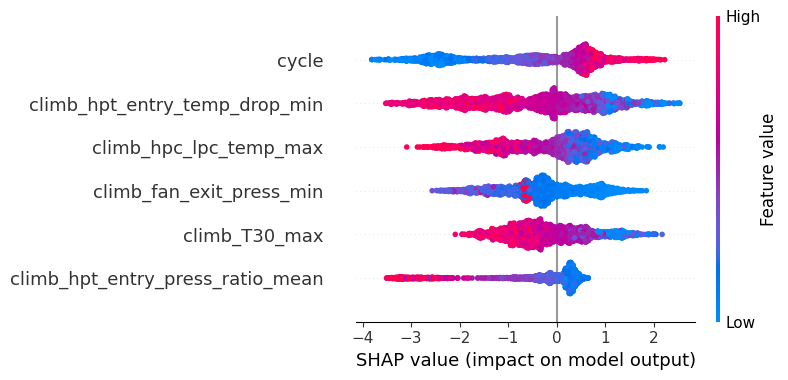

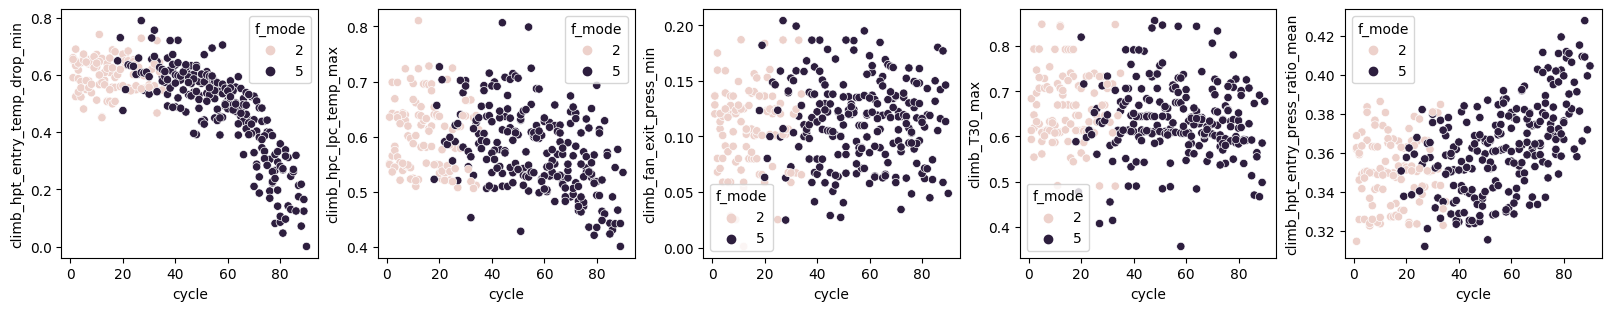

origin pred health vs failure : 111 vs 230
adjust pred health vs failure : 118 vs 223


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [451]:
# hpt
label_idx = 5
hpt_X_test, hpt_y_test = getModeData('hpt', 'test')
hpt_total = getTotalDf(hpt_X_test, hpt_y_test)

hpt_cols = ['climb_hpt_entry_temp_drop_min', 'climb_hpc_lpc_temp_max', 'climb_fan_exit_press_min', 'climb_T30_max', 'climb_hpt_entry_press_ratio_mean']

shap.summary_plot(shap_values[label_idx], xgb_X_test, class_names=xgb_label_dic, max_display=6)
show_scatterplot(hpt_total, hpt_cols, 'cycle', 'f_mode')

all_hpt_top_feature_list = {'climb_hpt_entry_temp_drop_min':'max', 'climb_hpt_entry_press_ratio_mean' : 'max'}
all_hpt_adj = changeValue(hpt_total, all_hpt_top_feature_list)

all_hpt_adj_pred = eval_xgb(all_hpt_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), all_hpt_adj['f_mode'])
df_all_hpt_adj_pred = pd.DataFrame(all_hpt_adj_pred, columns=['f_mode'])

print(f'origin pred health vs failure : {len(all_hpt_adj.loc[all_hpt_adj.f_mode == 2])} vs {len(all_hpt_adj.loc[all_hpt_adj.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_all_hpt_adj_pred.loc[df_all_hpt_adj_pred.f_mode == 2])} vs {len(df_all_hpt_adj_pred.loc[df_all_hpt_adj_pred.f_mode != 2])}')

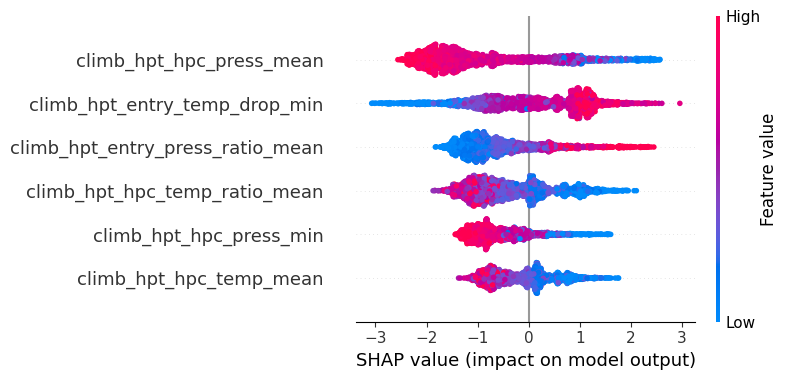

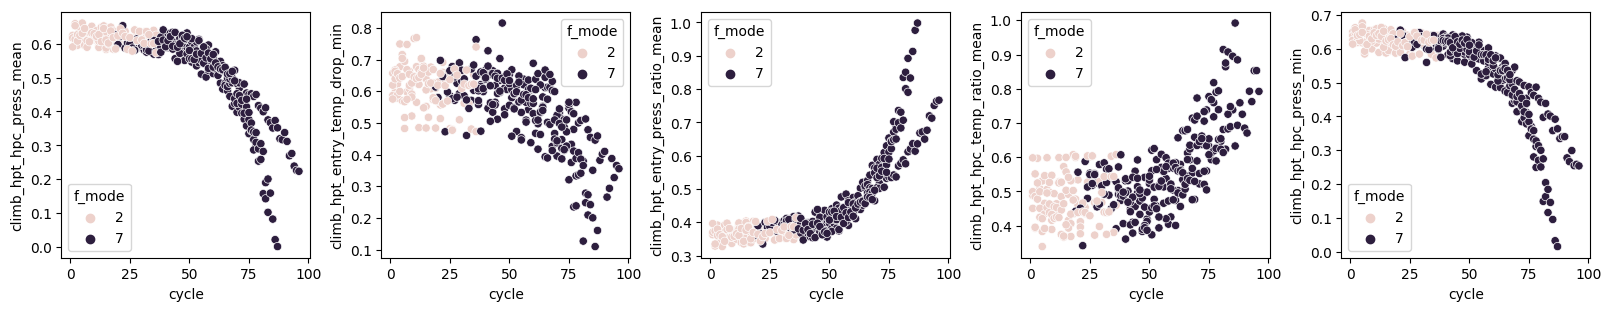

origin pred health vs failure : 113 vs 231
adjust pred health vs failure : 115 vs 229


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [452]:
# lpt
label_idx = 7
lpt_X_test, lpt_y_test = getModeData('lpt', 'test')
lpt_total = getTotalDf(lpt_X_test, lpt_y_test)

lpt_cols = ['climb_hpt_hpc_press_mean', 'climb_hpt_entry_temp_drop_min', 'climb_hpt_entry_press_ratio_mean', 'climb_hpt_hpc_temp_ratio_mean', 'climb_hpt_hpc_press_min']

shap.summary_plot(shap_values[label_idx], xgb_X_test, class_names=xgb_label_dic, max_display=6)
show_scatterplot(lpt_total, lpt_cols, 'cycle', 'f_mode')

all_lpt_top_feature_list = {'climb_hpt_hpc_press_mean':'quantile/0.75', 'climb_hpt_entry_press_ratio_mean':'quantile/0.25', 'climb_hpt_hpc_press_min':'quantile/0.75'}
all_lpt_adj = changeValue(lpt_total, all_lpt_top_feature_list)

all_lpt_adj_pred = eval_xgb(all_lpt_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), all_lpt_adj['f_mode'])
df_all_lpt_adj_pred = pd.DataFrame(all_lpt_adj_pred, columns=['f_mode'])

print(f'origin pred health vs failure : {len(all_lpt_adj.loc[all_lpt_adj.f_mode == 2])} vs {len(all_lpt_adj.loc[all_lpt_adj.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_all_lpt_adj_pred.loc[df_all_lpt_adj_pred.f_mode == 2])} vs {len(df_all_lpt_adj_pred.loc[df_all_lpt_adj_pred.f_mode != 2])}')

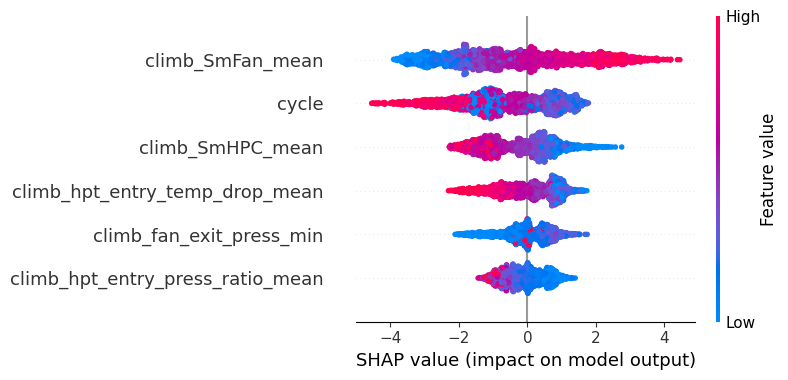

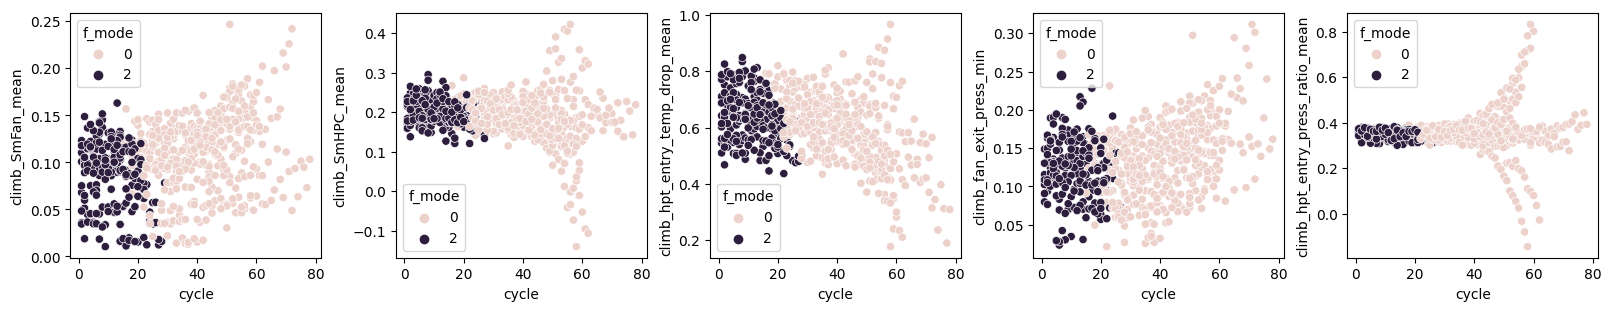

In [453]:
# all
label_idx = 0
all_X_test, all_y_test = getModeData('all', 'test')
all_total = getTotalDf(all_X_test, all_y_test)

all_cols = ['climb_SmFan_mean', 'climb_SmHPC_mean', 'climb_hpt_entry_temp_drop_mean', 'climb_fan_exit_press_min', 'climb_hpt_entry_press_ratio_mean']

shap.summary_plot(shap_values[label_idx], xgb_X_test, class_names=xgb_label_dic, max_display=6)
show_scatterplot(all_total, all_cols, 'cycle', 'f_mode')

In [476]:
# fan 조건으로 교체
all_fan_adj = changeValue(all_total, all_fan_top_feature_list)

all_fan_adj_pred = eval_xgb(all_fan_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), all_fan_adj['f_mode'])
df_all_fan_adj_pred = pd.DataFrame(all_fan_adj_pred, columns=['f_mode'])
all_fan_adj['pred'] = df_all_fan_adj_pred.values

print(f'origin pred health vs failure : {len(all_y_test.loc[all_y_test.f_mode == 2])} vs {len(all_y_test.loc[all_y_test.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_all_fan_adj_pred.loc[df_all_fan_adj_pred.f_mode == 2])} vs {len(df_all_fan_adj_pred.loc[df_all_fan_adj_pred.f_mode != 2])}')

origin pred health vs failure : 208 vs 412
adjust pred health vs failure : 239 vs 381


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [478]:
# hpc 조건으로 교체
all_hpc_adj = changeValue(all_total, all_hpc_top_feature_list)

all_hpc_adj_pred = eval_xgb(all_hpc_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), all_hpc_adj['f_mode'])
df_all_hpc_adj_pred = pd.DataFrame(all_hpc_adj_pred, columns=['f_mode'])
all_hpc_adj['pred'] = df_all_hpc_adj_pred.values

print(f'origin pred health vs failure : {len(all_y_test.loc[all_y_test.f_mode == 2])} vs {len(all_y_test.loc[all_y_test.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_all_hpc_adj_pred.loc[df_all_hpc_adj_pred.f_mode == 2])} vs {len(df_all_hpc_adj_pred.loc[df_all_hpc_adj_pred.f_mode != 2])}')

origin pred health vs failure : 208 vs 412
adjust pred health vs failure : 219 vs 401


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [479]:
# hpt 조건으로 교체
all_hpt_adj = changeValue(all_total, all_hpt_top_feature_list)

all_hpt_adj_pred = eval_xgb(all_hpt_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), all_hpt_adj['f_mode'])
df_all_hpt_adj_pred = pd.DataFrame(all_hpt_adj_pred, columns=['f_mode'])
all_hpt_adj['pred'] = df_all_hpt_adj_pred.values

print(f'origin pred health vs failure : {len(all_y_test.loc[all_y_test.f_mode == 2])} vs {len(all_y_test.loc[all_y_test.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_all_hpt_adj_pred.loc[df_all_hpt_adj_pred.f_mode == 2])} vs {len(df_all_hpt_adj_pred.loc[df_all_hpt_adj_pred.f_mode != 2])}')

origin pred health vs failure : 208 vs 412
adjust pred health vs failure : 232 vs 388


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [483]:
# lpt 조건으로 교체
all_lpt_adj = changeValue(all_total, all_lpt_top_feature_list)

all_lpt_adj_pred = eval_xgb(all_lpt_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), all_lpt_adj['f_mode'])
df_all_lpt_adj_pred = pd.DataFrame(all_lpt_adj_pred, columns=['f_mode'])
all_lpt_adj['pred'] = df_all_lpt_adj_pred.values

print(f'origin pred health vs failure : {len(all_y_test.loc[all_y_test.f_mode == 2])} vs {len(all_y_test.loc[all_y_test.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_all_lpt_adj_pred.loc[df_all_lpt_adj_pred.f_mode == 2])} vs {len(df_all_lpt_adj_pred.loc[df_all_lpt_adj_pred.f_mode != 2])}')

origin pred health vs failure : 208 vs 412
adjust pred health vs failure : 216 vs 404


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [484]:
result_df = all_total.groupby(['fileNo', 'unit'])['cycle'].count().reset_index()
result_df['healty'] = all_total.loc[all_total.f_mode == 2].groupby(['fileNo', 'unit'])['cycle'].count().reset_index()['cycle']
result_df['fan'] = all_fan_adj.loc[all_fan_adj.pred == 2].groupby(['fileNo', 'unit'])['cycle'].count().reset_index()['cycle']
result_df['hpc'] = all_hpc_adj.loc[all_hpc_adj.pred == 2].groupby(['fileNo', 'unit'])['cycle'].count().reset_index()['cycle']
result_df['hpt'] = all_hpt_adj.loc[all_hpt_adj.pred == 2].groupby(['fileNo', 'unit'])['cycle'].count().reset_index()['cycle']
result_df['lpt'] = all_lpt_adj.loc[all_lpt_adj.pred == 2].groupby(['fileNo', 'unit'])['cycle'].count().reset_index()['cycle']
result_df

,fileNo,unit,cycle,healty,fan,hpc,hpt,lpt
0,7.0,10.0,78,29,34,28,33,30
1,7.0,11.0,60,20,25,22,23,22
2,7.0,12.0,58,17,17,17,17,16
3,7.0,13.0,56,14,17,16,17,16
4,7.0,14.0,59,15,17,17,18,17
5,7.0,15.0,72,27,32,29,30,29
6,8.0,7.0,62,22,24,23,24,22
7,8.0,8.0,62,22,24,22,23,20
8,8.0,9.0,59,21,24,23,23,21
9,8.0,10.0,54,21,25,22,24,23


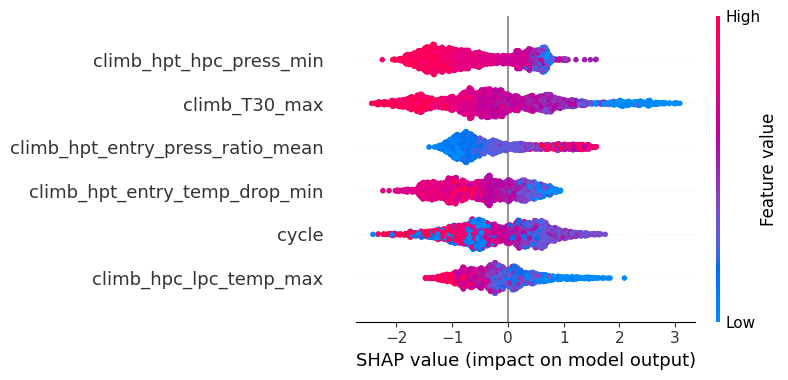

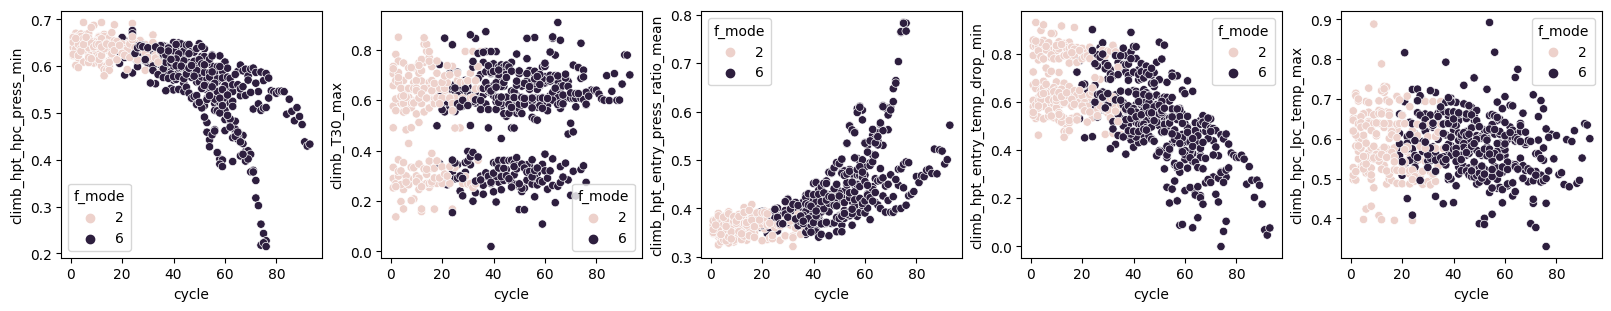

In [485]:
# hpt_lpt
label_idx = 6
hpt_lpt_X_test, hpt_lpt_y_test = getModeData('hpt_lpt', 'test')
hpt_lpt_total = getTotalDf(hpt_lpt_X_test, hpt_lpt_y_test)

hpt_lpt_cols = ['climb_hpt_hpc_press_min', 'climb_T30_max', 'climb_hpt_entry_press_ratio_mean', 'climb_hpt_entry_temp_drop_min', 'climb_hpc_lpc_temp_max']

shap.summary_plot(shap_values[label_idx], xgb_X_test, class_names=xgb_label_dic, max_display=6)
show_scatterplot(hpt_lpt_total, hpt_lpt_cols, 'cycle', 'f_mode')

In [490]:
# hpt 조건으로 교체
hpt_lpt_hpt_adj = changeValue(hpt_lpt_total, all_hpt_top_feature_list)

hpt_lpt_hpt_adj_pred = eval_xgb(hpt_lpt_hpt_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), hpt_lpt_hpt_adj['f_mode'])
df_hpt_lpt_hpt_adj_pred = pd.DataFrame(hpt_lpt_hpt_adj_pred, columns=['f_mode'])
hpt_lpt_hpt_adj['pred'] = df_hpt_lpt_hpt_adj_pred.values

print(f'origin pred health vs failure : {len(hpt_lpt_y_test.loc[hpt_lpt_y_test.f_mode == 2])} vs {len(hpt_lpt_y_test.loc[hpt_lpt_y_test.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_hpt_lpt_hpt_adj_pred.loc[df_hpt_lpt_hpt_adj_pred.f_mode == 2])} vs {len(df_hpt_lpt_hpt_adj_pred.loc[df_hpt_lpt_hpt_adj_pred.f_mode != 2])}')

origin pred health vs failure : 218 vs 408
adjust pred health vs failure : 209 vs 417


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [491]:
# lpt 조건으로 교체
hpt_lpt_lpt_adj = changeValue(hpt_lpt_total, all_lpt_top_feature_list)

hpt_lpt_lpt_adj_pred = eval_xgb(hpt_lpt_lpt_adj.drop(['f_mode', 'unit', 'fileNo'], axis=1), hpt_lpt_lpt_adj['f_mode'])
df_hpt_lpt_lpt_adj_pred = pd.DataFrame(hpt_lpt_lpt_adj_pred, columns=['f_mode'])
hpt_lpt_lpt_adj['pred'] = df_hpt_lpt_lpt_adj_pred.values

print(f'origin pred health vs failure : {len(hpt_lpt_y_test.loc[hpt_lpt_y_test.f_mode == 2])} vs {len(hpt_lpt_y_test.loc[hpt_lpt_y_test.f_mode != 2])}')
print(f'adjust pred health vs failure : {len(df_hpt_lpt_lpt_adj_pred.loc[df_hpt_lpt_lpt_adj_pred.f_mode == 2])} vs {len(df_hpt_lpt_lpt_adj_pred.loc[df_hpt_lpt_lpt_adj_pred.f_mode != 2])}')

origin pred health vs failure : 218 vs 408
adjust pred health vs failure : 214 vs 412


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
